## Problem 3 ##
Deliverable: write a likelihood model that provides a reasonable fit for this data
- plot simulations from this model to assess its viability
- fit a gompertz function to this data
- provide the best estimate for parameters a, b, and c

- wrtie an optimization problem to estimate them using max likelihood
- extend this model to a bayesian inference problem
- write as a penalized likelihood prob
- write as a least squares optimization problem

##### References
1. https://github.com/markdregan/Bayesian-Modelling-in-Python
2. https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html 
3. https://m-clark.github.io/models-by-example/penalized-maximum-likelihood.html 
4. https://python.quantecon.org/mle.html

I will assume normal noise in the gompertz pdf for the data.
We start with problem 
### 3a


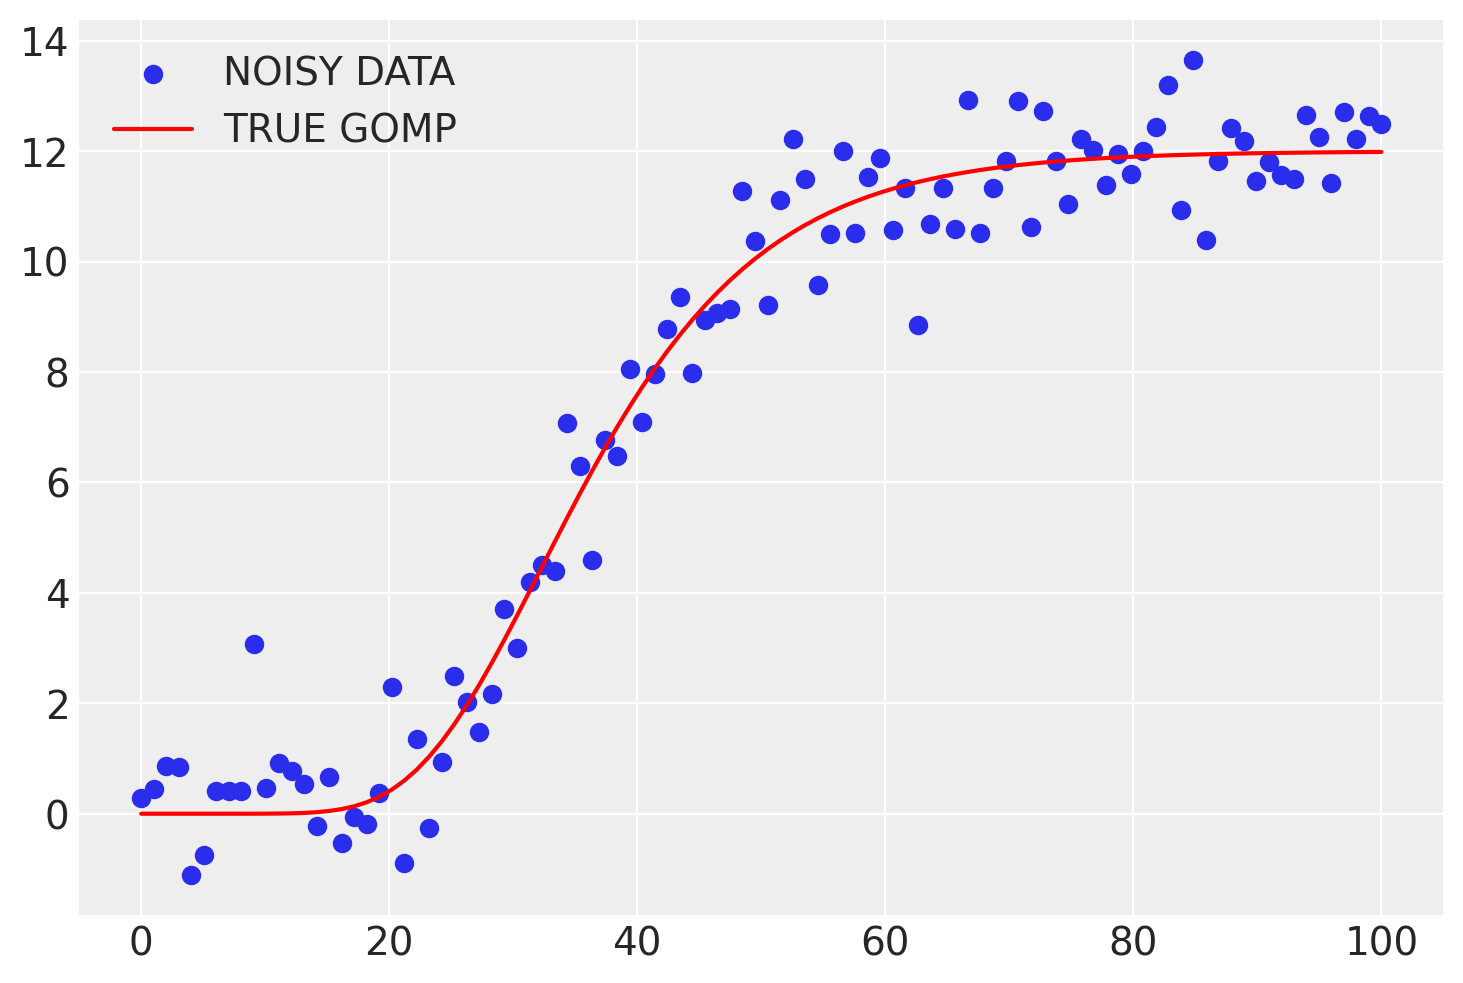

In [53]:
# write a likelihood model for a gompertz function 
import os
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

# GOMP LIKELIHOOD
def gomp(a, b, c, x):
    y_i = a * np.exp(-b * np.exp(-c * x))
    return y_i

def gomp_with_noise(a, b, c, x):
    noise = np.random.normal(0, 0.8, size=len(x))
    y_i = a * np.exp(-b * np.exp(-c * x)) + noise
    return y_i

# arb data
x_values = np.linspace(0, 100, 100)

# GOMP SHAPE
aa, bb, cc = 12, 25, 0.1
yy = gomp_with_noise(aa, bb, cc, x_values)

# NOISY GOMP
y_values = gomp(aa, bb, cc, x_values)

# PLOT NOISY GOMP
plt.scatter(x_values, yy, label="NOISY DATA")
plt.plot(x_values, y_values, color='r', label="TRUE GOMP")
plt.legend()
plt.show()
    

### 3b - fit a curve to the gompertz likelihood function with maximum likelihood estimation ###


MLE estimates: a=12.122796436768574, b=15.035212734459344, c=0.08427598186034382, sigma=1.0342808221768172


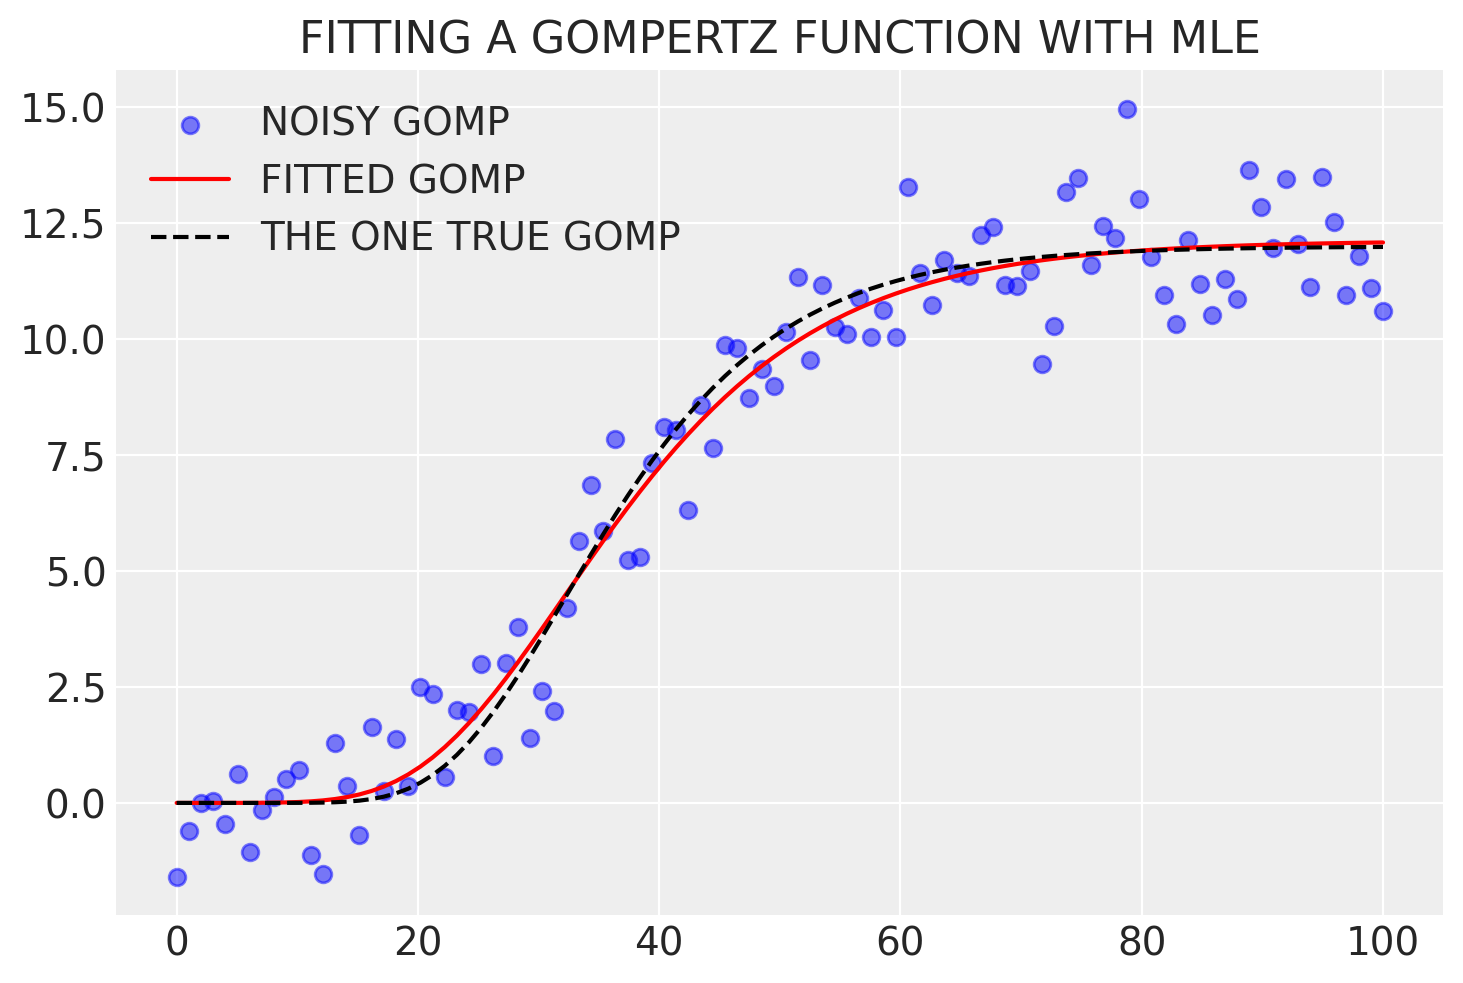

In [54]:
### WRITE LIKELIHOOD WITH MLE ###
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Gompertz function
def gomp(a, b, c, x):
    y_i = a * np.exp(-b * np.exp(-c * x))
    return y_i

# log likelihood for mse
# treat all params as gaussian random variables including sigma
# make MLE easy to solve 
def nll_1(parameters, x, y_obs):
    a, b, c, sigma = parameters
    y_pred = gomp(a, b, c, x)
    # 
    nll = 0.5 * np.sum(((y_obs - y_pred) / sigma) ** 2 + np.log(2 * np.pi * sigma ** 2))
    return nll

# arb data
x_values = np.linspace(0, 100, 100)
noise = np.random.normal(0, 0.8, size=len(x_values))

# GOMP SHAPE
aa, bb, cc = 12, 25, 0.1
# Generate some arbitrary noisy Gompertz data
x_values = np.linspace(0, 100, 100)
# true shapes
aa, bb, cc = 12, 25, 0.1  # 
# true gomp
yy = gomp(aa, bb, cc, x_values) #
# mysterynoise
noise = np.random.normal(0, 1, size=len(x_values))  # 

# noisy GOMP
y_values = yy + noise

# initial guess for mle
initial_guess = [10, 15, 0.05, 1]  
# optimization in scipy
result = minimize(nll_1, initial_guess, args=(x_values, y_values), method='L-BFGS-B')

# what do we have now
a_mle, b_mle, c_mle, sigma_mle = result.x
print(f"MLE estimates: a={a_mle}, b={b_mle}, c={c_mle}, sigma={sigma_mle}")

# Plot the noisy data and the fitted Gompertz curve
plt.scatter(x_values, y_values, label="NOISY GOMP", color="blue", alpha=0.5)
plt.plot(x_values, gomp(a_mle, b_mle, c_mle, x_values), color='red', label="FITTED GOMP")
plt.plot(x_values, yy, color='black', linestyle='--', label="THE ONE TRUE GOMP")
plt.legend()
plt.title("FITTING A GOMPERTZ FUNCTION WITH MLE")
plt.show()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 19 seconds.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.


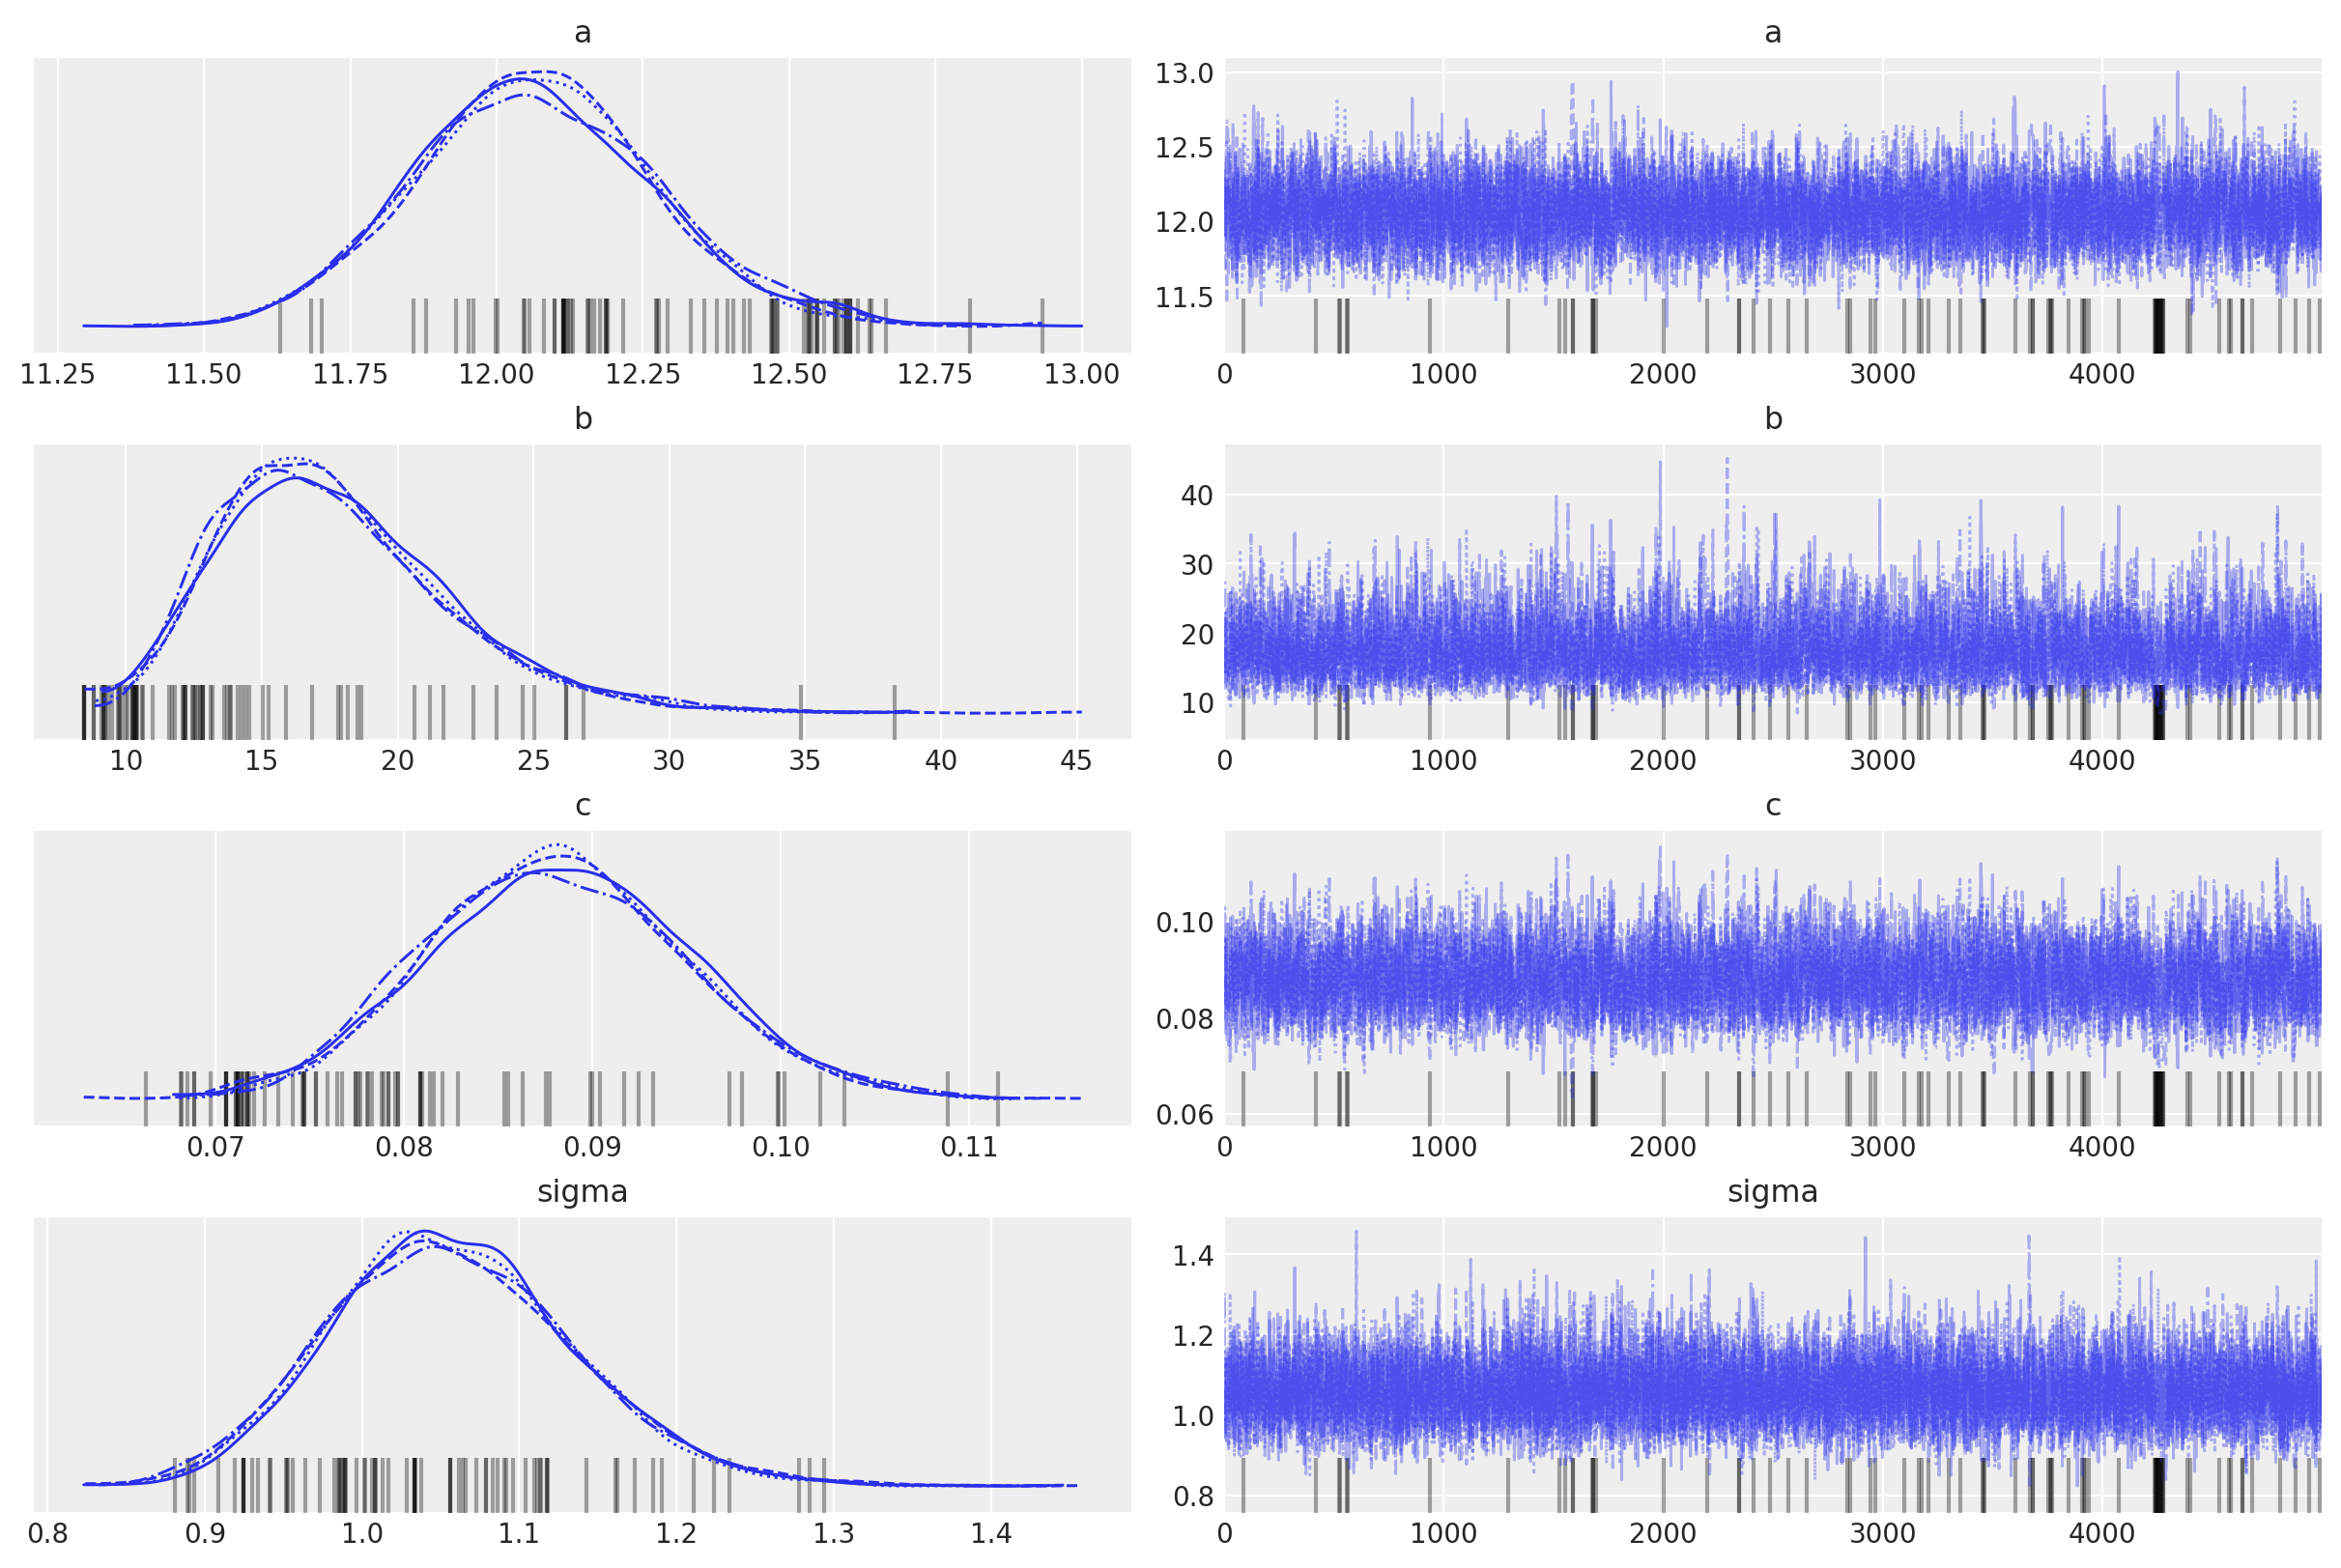

Sampling: [y_likelihood]


Output()

         mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
a      12.067  0.207    11.659     12.475      0.003    0.002    6170.0   
b      17.683  4.283    10.219     26.203      0.065    0.046    4029.0   
c       0.088  0.007     0.075      0.102      0.000    0.000    3993.0   
sigma   1.058  0.077     0.910      1.207      0.001    0.001    8220.0   

       ess_tail  r_hat  
a        4378.0    1.0  
b        4020.0    1.0  
c        3384.0    1.0  
sigma    7525.0    1.0  


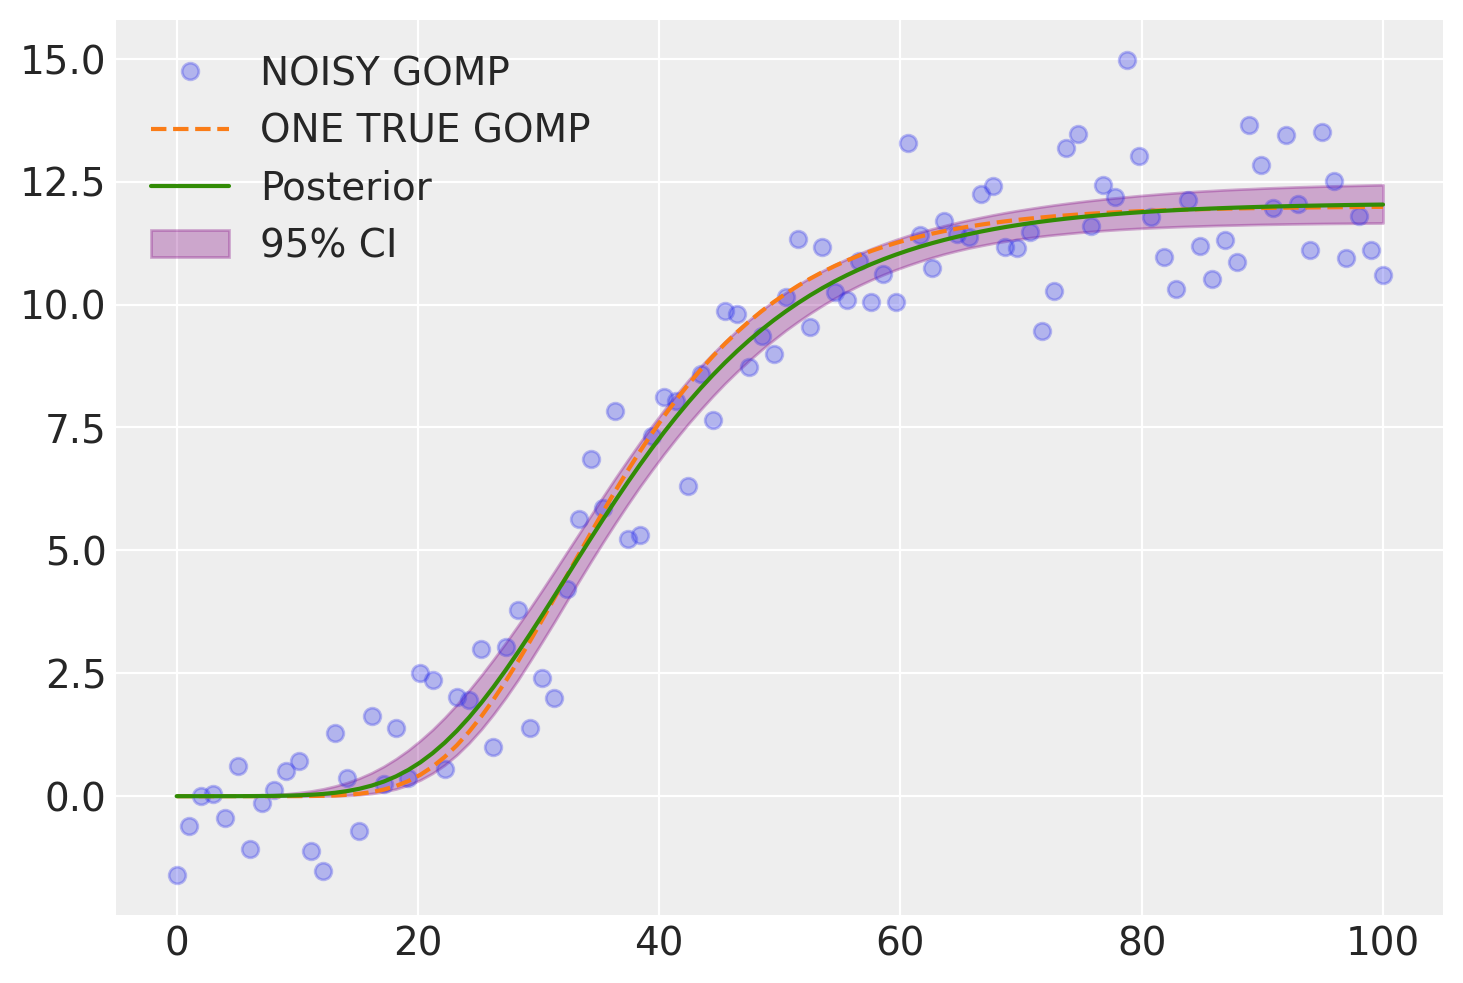

In [55]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

np.random.seed(42)

y_values = yy + noise
initial_guess = [10, 15, 0.05, 1]  

# optimizer
result = minimize(nll_1, initial_guess, args=(x_values, y_values), method='L-BFGS-B')

### bayesian inf problem below ###
# Bayesian Inference PYMC
with pm.Model() as model:
    # Priors
    a = pm.Normal('a', mu=10, sigma=5) 
    b = pm.Normal('b', mu=20, sigma=10) 
    c = pm.Normal('c', mu=0.1, sigma=0.05) 
    sigma = pm.HalfNormal('sigma', sigma=1) 
    
    # gomp
    y_model = gomp(a, b, c, x_values)
    
    # likelihood
    y_likelihood = pm.Normal('y_likelihood', mu=y_model, sigma=sigma, observed=y_values)
    trace = pm.sample(5000, return_inferencedata=True, random_seed=42)
    
# plot posterior
az.plot_trace(trace)
plt.show()
print(az.summary(trace, hdi_prob=0.95))

# sample posterior
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace)

posterior_samples_a = trace.posterior['a'].values.flatten()
posterior_samples_b = trace.posterior['b'].values.flatten()
posterior_samples_c = trace.posterior['c'].values.flatten()

y_model_samples = np.array([gomp(a_i, b_i, c_i, x_values) for a_i, b_i, c_i in zip(posterior_samples_a, posterior_samples_b, posterior_samples_c)])

plt.plot(x_values, y_values, 'o', alpha = 0.3, label="NOISY GOMP")
plt.plot(x_values, yy, '--', label="ONE TRUE GOMP")
plt.plot(x_values, np.mean(y_model_samples, axis=0), label="Posterior")
plt.fill_between(x_values, 
                 np.percentile(y_model_samples, 2.5, axis=0),
                 np.percentile(y_model_samples, 97.5, axis=0), 
                 color='purple', alpha=0.3, label="95% CI")
plt.legend()
plt.show()



In [ ]:
d. Now write this as a penalized likelihood model
e. Now write this as a least squares optimization problem.


BELOW HERE IS PLAYGROUND

\text{LS} = \sum (y_{\text{obs}} - y_{\text{pred}})^2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


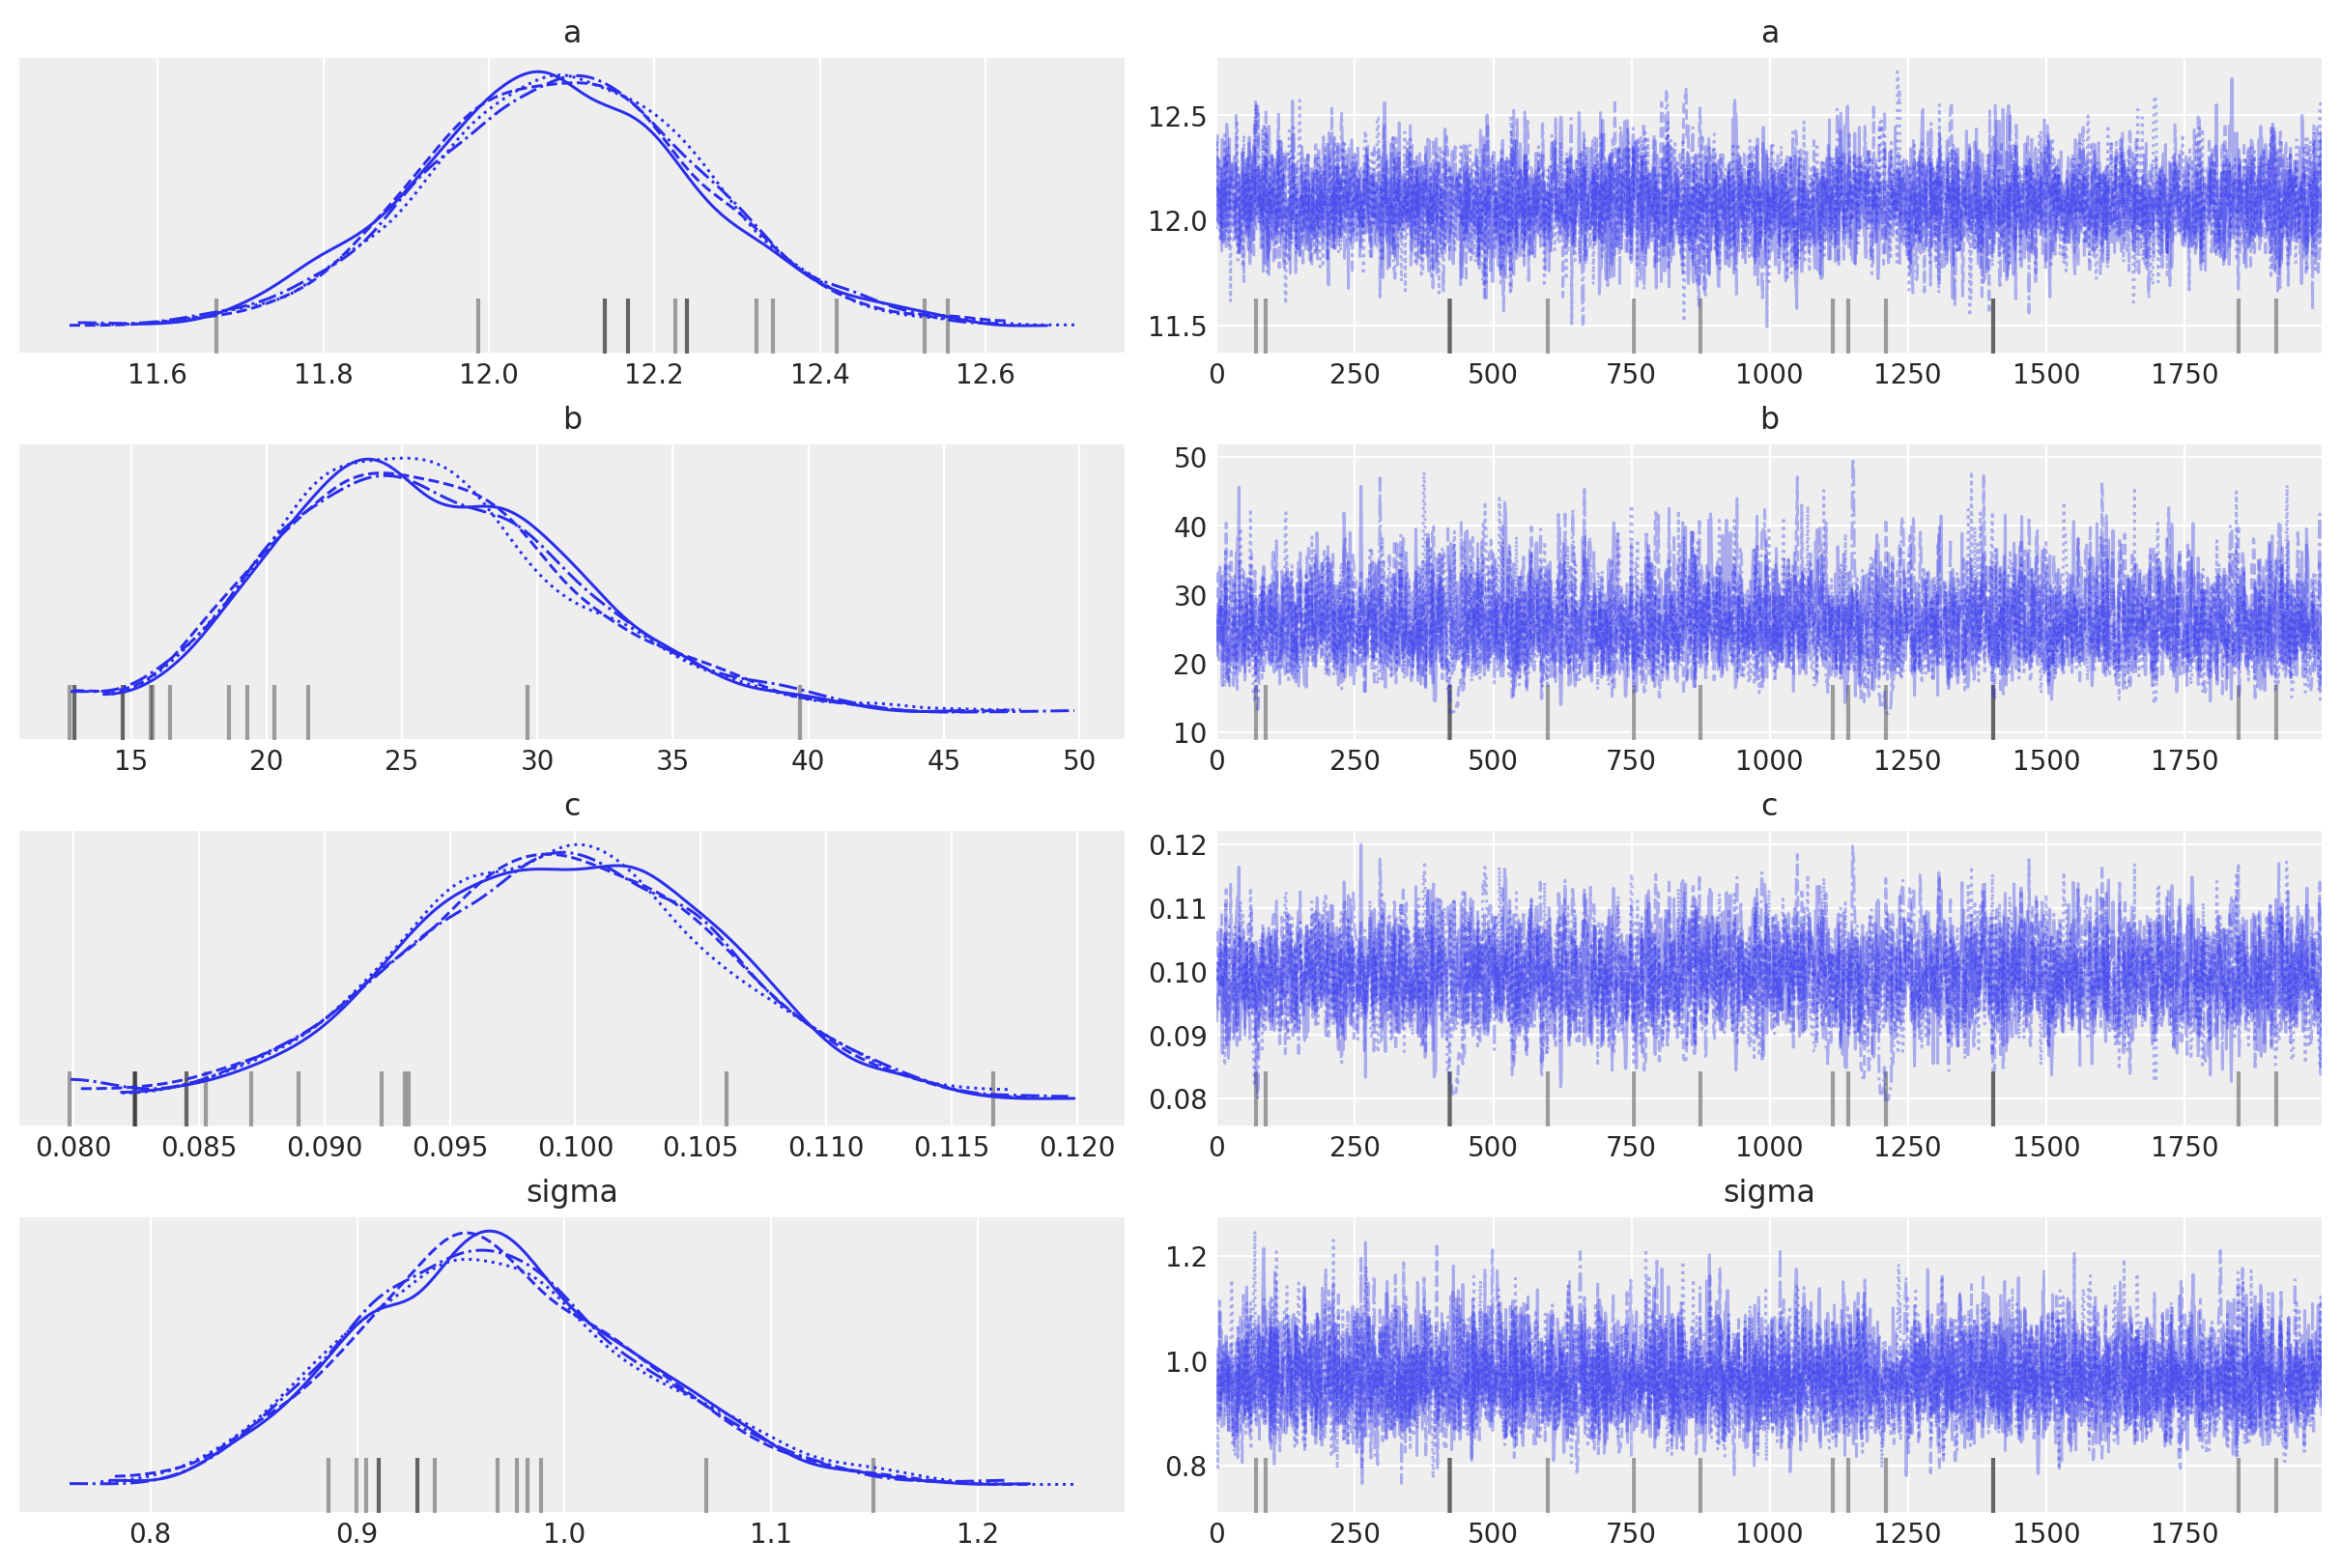

         mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
a      12.088  0.168    11.756     12.421      0.003    0.002    3910.0   
b      25.948  5.471    15.724     36.663      0.113    0.080    2075.0   
c       0.099  0.006     0.087      0.111      0.000    0.000    2002.0   
sigma   0.968  0.070     0.831      1.101      0.001    0.001    4984.0   

       ess_tail  r_hat  
a        3030.0    1.0  
b        1397.0    1.0  
c        1398.0    1.0  
sigma    4386.0    1.0  


In [56]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from scipy.optimize import minimize

np.random.seed(42)

# Gompertz function
def gomp(a, b, c, x):
    return a * np.exp(-b * np.exp(-c * x))

# log likelihood for mse
def nll_1(parameters, x, y_obs):
    a, b, c, sigma = parameters
    y_pred = gomp(a, b, c, x)
    nll = 0.5 * np.sum(((y_obs - y_pred) / sigma) ** 2 + np.log(2 * np.pi * sigma ** 2))
    return nll

# arb data
x_values = np.linspace(0, 100, 100)
noise = np.random.normal(0, 0.8, size=len(x_values))

# GOMP SHAPE
aa, bb, cc = 12, 25, 0.1
# true gomp
yy = gomp(aa, bb, cc, x_values)
noise = np.random.normal(0, 1, size=len(x_values))  # Simulated noise
y_values = yy + noise  # Noisy Gompertz data

# initial guess for MLE
initial_guess = [10, 15, 0.05, 1]
# optimization in scipy
result = minimize(nll_1, initial_guess, args=(x_values, y_values), method='L-BFGS-B')
a_mle, b_mle, c_mle, sigma_mle = result.x

### Bayesian inference ###
with pm.Model() as model:
    # priors w noise
    a = pm.Normal('a', mu=10, sigma=5)
    b = pm.Normal('b', mu=20, sigma=10)
    c = pm.Normal('c', mu=0.1, sigma=0.05)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # GOMP
    y_model = gomp(a, b, c, x_values)
    
    # Likelihood = gomp with gaus noise
    y_likelihood = pm.Normal('y_likelihood', mu=y_model, sigma=sigma, observed=y_values)
    trace = pm.sample(2000, return_inferencedata=True, random_seed=42)

# plot posterior
az.plot_trace(trace)
plt.show()

# Summary of posterior
print(az.summary(trace, hdi_prob=0.95))
